## Práctico 5: Volcano Crossing

In [1]:
from volcano_crossing_env import VolcanoCrossing

env = VolcanoCrossing(slip_prob=0.5)

In [2]:
env.reset()

'21'

### Jugar manualmente

In [3]:
def run_game():
        print("Play manually...")
        obs = env.reset()
        print(obs)
        done = False
        step_counter = 0
        all_rewards = 0
        env.render()

        while not done:
            action = input("Next action: ")
            env.check_action(action)
            obs, reward, done_env, _ = env.step(action)
            print(f'{obs=} {reward=} {done_env=}')
            all_rewards += reward
            done = done_env
            env.render()
            step_counter += 1

In [ ]:
#run_game()

### Jugar con una policy

In [3]:
def policy_south(state) :
  return 'S' # Parte 1: S > N >>> W >>> E

In [4]:
def run(policy) :
  U = 0
  done = False
  state = env.reset()
  while not done:
    state, reward, done, _ = env.step(policy(state))
    U += reward
  return U

In [5]:
run(policy_south)

2

### Estimación de la policy por promedio

In [6]:
r = 0
N = 50_000
for i in range(N):
    r += run(policy_south)

print (f'Average reward: {r/N}')

Average reward: -5.27432


### Policy Evaluation

In [13]:
def policy_evaluation(policy, delta = 0.05, gamma = 0.999):
  V = { '11':0, '12':0, '13':0, '14':0, '21':0, '22':0, '23':0, '24':0, '31':0, '32':0, '33':0, '34':0 }
  V_new = { '11':0, '12':0, '13':0, '14':0, '21':0, '22':0, '23':0, '24':0, '31':0, '32':0, '33':0, '34':0 }
  max_diff = delta + 1

  while max_diff > delta:
    for s in env.observation_space:
      a = policy[s]
      q = 0
      for s_prime in env.P[s][a].keys():
        q += env.P[s][a][s_prime] * (env.R[s][a][s_prime] + gamma * V[s_prime])
      V_new[s] = q
    max_diff = 0
    for s in V.keys():
      max_diff = max(max_diff, abs(V[s]-V_new[s]))
    V = V_new.copy()
  return V

In [9]:
V = policy_evaluation(policy_south, delta = 0.05, gamma = 0.999)
print(V)

{'11': -10.097479836569216, '12': -25.02876509699797, '13': 0.0, '14': 0.0, '21': -5.153966059429463, '22': -21.73443636193771, '23': 0.0, '24': -21.539534697673236, '31': 0.0, '32': -16.790727065526983, '33': -30.83304348111256, '34': -25.988180160178665}


### Policy Improvement

In [10]:
policies = { '11':'S', '12':'S', '13':'S', '14':'S', '21':'S', '22':'S', '23':'S', '24':'S', '31':'S', '32':'S', '33':'S', '34':'S' }

In [50]:
actions = ['N', 'S', 'E', 'W']

# Realizar un paso de policy improvement
def policy_improvement(V, policies, gamma = 0.999):
  U = policy_evaluation(policies, delta = 0.05, gamma = gamma)
  pi = policies.copy()

  for s in pi:
    piAux = pi.copy()
    for action in actions:
      piAux[s] = action
      q = policy_evaluation(piAux, delta = 0.05, gamma = gamma)
      if q[s] > U[s]:
        pi[s] = action

  return pi


policies = policy_improvement(V, policies, gamma = 0.999)
print(policies)

{'11': 'S', '12': 'W', '13': 'N', '14': 'N', '21': 'S', '22': 'W', '23': 'N', '24': 'N', '31': 'N', '32': 'W', '33': 'E', '34': 'N'}


### Policy Iteration

In [51]:
# Realizar policy iteration y ver cuál es la mejor acción para cada estado

from collections import defaultdict
valuesPI = []
policies = { '11':'S', '12':'S', '13':'S', '14':'S', '21':'S', '22':'S', '23':'S', '24':'S', '31':'S', '32':'S', '33':'S', '34':'S' }
policies_eval_value = policy_evaluation(policies, delta = 0.05, gamma = 0.999)
while True:
    new_pol = policy_improvement(V, policies)
    new_pol_eval_value = policy_evaluation(new_pol, delta = 0.05, gamma = 0.999)
    if new_pol_eval_value == policies_eval_value: # pi == pi'
        break
    policies = new_pol.copy()
    policies_eval_value = new_pol_eval_value.copy()
    valuesPI.append(policies_eval_value.copy())
    
print("Final policy:")
for s in policies.keys():
    print(f"State {s}: {policies[s]}")


Final policy:
State 11: S
State 12: W
State 13: S
State 14: S
State 21: S
State 22: W
State 23: S
State 24: N
State 31: S
State 32: W
State 33: E
State 34: N


# Value Iteration

In [ ]:
values = []

def value_iteration(env, delta=0.05, gamma=0.999):
    miniDelta = delta + 1
    t = 0
    policiesOpt = {}

    valuesOpt = {}
    
    # Initialize values for all states in env.observation_space
    for s in env.observation_space:
        valuesOpt[s] = 0

    values.append(valuesOpt.copy())
    while miniDelta > delta:
        miniDelta = 0
        t += 1
        for s in env.observation_space:
            # Ensure state exists in env.P
            if s not in env.P:
                raise KeyError(f"State {s} not found in env.P")
            
            valuesOpt[s] = max(q_value(env, s, a, values[t-1], gamma) for a in actions)
            policiesOpt[s] = max(actions, key=lambda a: q_value(env, s, a, values[t-1], gamma))
        
        values.append(valuesOpt.copy())
        for s in env.observation_space:
            diff = abs(values[t][s] - values[t-1][s])
            if diff > miniDelta:
                miniDelta = diff

    return policiesOpt

policypimba = value_iteration(env, delta=0.05, gamma=0.999)

def q_value(env, state, action, V, gamma):
    q = 0
    if state not in env.P or action not in env.P[state]:
        raise KeyError(f"State {state} or action {action} not found in env.P")
    for s_prime in env.P[state][action].keys():
        q += env.P[state][action][s_prime] * (env.R[state][action][s_prime] + gamma * V[s_prime])
    return q


# Grafica

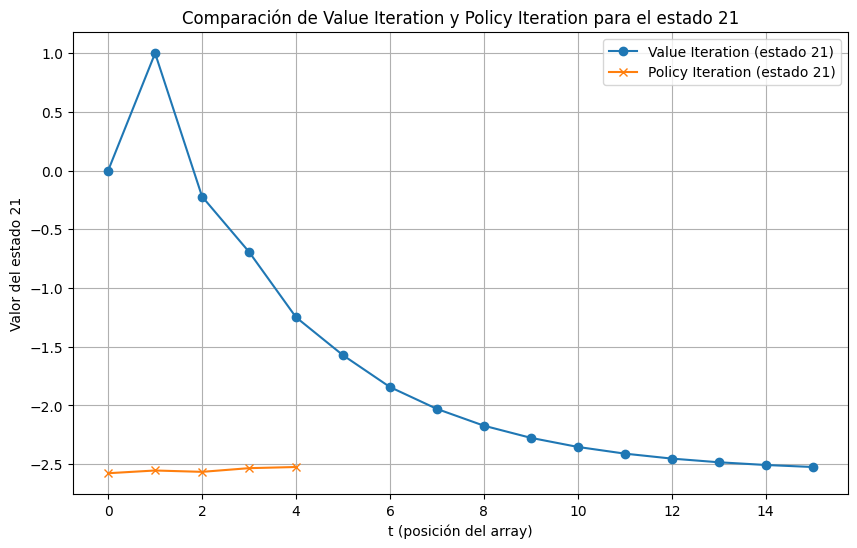

In [93]:
import matplotlib.pyplot as plt

# Extraer los valores de las policies para el estado "21"
values_21 = [v["21"] for v in values]
valuesPI_21 = [v["21"] for v in valuesPI]

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.plot(range(len(values_21)), values_21, label="Value Iteration (estado 21)", marker='o')
plt.plot(range(len(valuesPI_21)), valuesPI_21, label="Policy Iteration (estado 21)", marker='x')

# Configurar etiquetas y título
plt.xlabel("t (posición del array)")
plt.ylabel("Valor del estado 21")
plt.title("Comparación de Value Iteration y Policy Iteration para el estado 21")
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()